# Задание 1 (10 баллов)

Придумайте 5 категорий и сгенерируйте по 6 картинок на каждую (всего 30) с помощью генеративной diffusion модели и попытайтесь восстановить изначальное разбиение на категории из эмбеддингов картинок с помощью модели CLIP и любого алгоритма кластеризации. Проанализируйте результаты.

- Категории могут быть абсолютно любыми, главное чтобы они были действительно (по вашему мнению) визуально отличимы друг от друга (примеры: `архитектура`, `собаки`, `машины`, `свитеры`)
- Можете использовать `segmind/SSD-1B` из семинара или какую-то другую модели с huggingface (например, `stabilityai/stable-diffusion-xl-base-1.0`, `stabilityai/stable-diffusion-2-1`).
- каждый промпт должен быть полностью уникальным; внутри одного промпта и из промпта в промпт могут повторяться только предлоги/частицы/артикли; минимальная длина промпта - 10 слов; сохраните все промпты, которые вы использовали
- помимо промпта вам также нужно использовать параметры `guidance_scale`, `negative_prompt`, `height`, `width` (в разных промптах значения должны быть разными)
- используйте `generator = torch.Generator('cuda').manual_seed(12363)` для фиксации random_seed и воспроизводимости (*само значение вы можете подбирать в каждом отдельном случае пока не получится хорошая картинка*)
- сгенерированные картинки не должны быть идеальными, но должны хоть как-то отражать промпт; если у вас получается совсем что-то непонятное, то попытайтесь еще раз с другим seed или остальными параметрами;
- для наглядности напечатайте все картинки, но используйте to_256 из семинара, чтобы не перегружать ноутбук
- можете использовать любую clip модель (например `clip-vit-base-patch32` из семинара) для создания эмбедингов картинок (промпты эмбеддить не нужно)
- можете использовать любой алгоритм кластеризации, но лучше использовать алгоритмы с указанием количества кластеров; в целом постарайтесь получить как можно более хороший результат (даже если кластеризация совсем неверная, должна прослеживаться какая-то логика, результат не должен быть случайным);
- оценивайте качество кластеризации с помощью метрики ARI; лучшую модель разберите визуально - опишите как минимум 3 паттерна (не обязательно корректных), которые модель смогла уловить, а также 3 паттерна (если они есть), которые модель не распознала.

In [1]:
from torchvision import transforms
# это вспомогательные функции чтобы картинки были поменьше
to_512 = transforms.Resize(512)
to_256 = transforms.Resize(256)

In [106]:
from PIL import Image
import requests
from transformers import CLIPProcessor, CLIPModel

In [3]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [4]:
url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRF1IwK6-SxM83UpFVY6WtUZxXx-phss_gAUfdKbkTfau6VWVkt"
image = Image.open(requests.get(url, stream=True).raw)

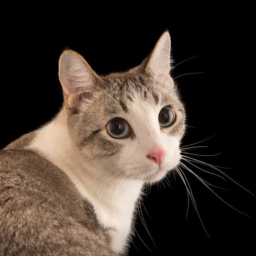

In [5]:
to_256(image)

In [6]:
inputs = processor(text=["a photo of a cat", "a photo of a dog"], images=image, return_tensors="pt", padding=True)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities

In [7]:
probs

tensor([[0.9954, 0.0046]], grad_fn=<SoftmaxBackward0>)

Это точно кошька

In [1]:
!pip install diffusers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.6 MB/s eta 0:00:00


In [2]:
import torch
from diffusers import StableDiffusionXLImg2ImgPipeline, StableDiffusionXLPipeline
from diffusers.utils import load_image
from PIL import Image
from torchvision import transforms
to_512 = transforms.Resize(512)
to_256 = transforms.Resize(256)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [3]:
pipe = StableDiffusionXLPipeline.from_pretrained("segmind/SSD-1B", torch_dtype=torch.float16, use_safetensors=True, variant="fp16")
_ = pipe.to("cuda")

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/577 [00:00<?, ?B/s]

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

scheduler/scheduler_config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/560 [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.77k [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/602 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/2.66G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Категории:


*   мороженое
*   обувь
*   дерево
*   лампа
*   большие кошки



## мороженое

In [24]:
prompt = 'A colorful bowl of ice cream topped with fresh fruit.'
# итоговый результат сильно зависит от случайного шума
# для воспроизводимости результатов можно зафиксировать seed и шум будет одинаковый
# и итоговая картинка тоже будет одинаковая при разных запусках
generator = generator=torch.Generator('cuda').manual_seed(12363)

gen_image_11 = pipe(prompt,
             generator=generator,
             height=640, # размер итоговой картинки
             width=640, # размер итоговой картинки
             guidance_scale=9.0, # значимость текстового промпта в диффузии, можно увеличить чтобы было больше похоже на промпт
             num_inference_steps=20, # количество шагов диффузии, чем больше тем лучше, но и дольше; поздние шаги изменяют все меньше и меньше
).images[0]

  0%|          | 0/20 [00:00<?, ?it/s]

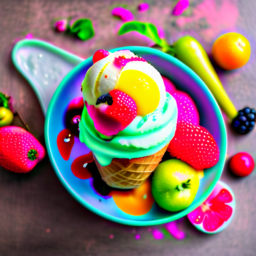

In [25]:
# seed 12362
to_256(gen_image_11)

In [26]:
prompt = 'A sundae with chocolate syrup and a cherry on top.'
# итоговый результат сильно зависит от случайного шума
# для воспроизводимости результатов можно зафиксировать seed и шум будет одинаковый
# и итоговая картинка тоже будет одинаковая при разных запусках
generator = generator=torch.Generator('cuda').manual_seed(12363)

gen_image_12 = pipe(prompt,
             generator=generator,
             height=768, # размер итоговой картинки
             width=1344, # размер итоговой картинки
             guidance_scale=7.0, # значимость текстового промпта в диффузии, можно увеличить чтобы было больше похоже на промпт
             num_inference_steps=20, # количество шагов диффузии, чем больше тем лучше, но и дольше; поздние шаги изменяют все меньше и меньше
).images[0]

  0%|          | 0/20 [00:00<?, ?it/s]

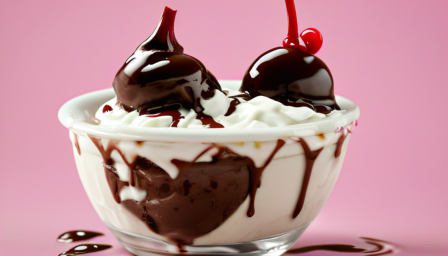

In [27]:
# seed 12362
to_256(gen_image_12)

In [30]:
prompt = 'A scoop of strawberry delight in a waffle cone.'

generator = generator=torch.Generator('cuda').manual_seed(12363)

gen_image_13 = pipe(prompt,
             generator=generator,
             height=880, # размер итоговой картинки
             width=1600, # размер итоговой картинки
             guidance_scale=4.0, # значимость текстового промпта в диффузии, можно увеличить чтобы было больше похоже на промпт
             num_inference_steps=20, # количество шагов диффузии, чем больше тем лучше, но и дольше; поздние шаги изменяют все меньше и меньше
).images[0]

  0%|          | 0/20 [00:00<?, ?it/s]

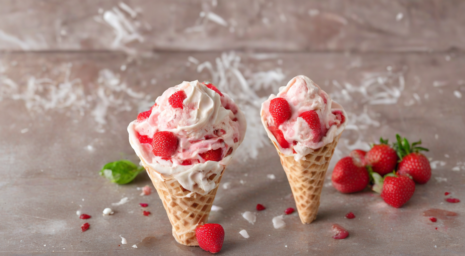

In [31]:
# seed 12362
to_256(gen_image_13)

  0%|          | 0/40 [00:00<?, ?it/s]

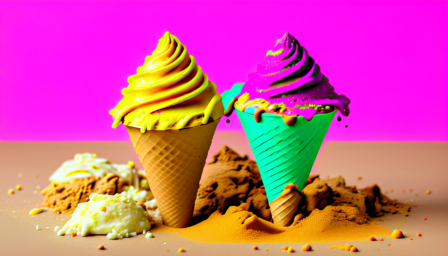

In [32]:
prompt = 'A cone with three scoops of desert in vibrant colors'

generator = generator=torch.Generator('cuda').manual_seed(12363)

gen_image_14 = pipe(prompt,
             generator=generator,
             height=768, # размер итоговой картинки
             width=1344, # размер итоговой картинки
             guidance_scale=9.5, # значимость текстового промпта в диффузии, можно увеличить чтобы было больше похоже на промпт
             num_inference_steps=40, # количество шагов диффузии, чем больше тем лучше, но и дольше; поздние шаги изменяют все меньше и меньше
).images[0]
# seed 12362
to_256(gen_image_14)

  0%|          | 0/50 [00:00<?, ?it/s]

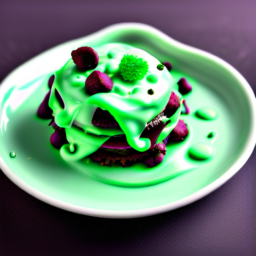

In [37]:
prompt = 'Mint chocolate chip treat in a fancy glass dish.'

generator = generator=torch.Generator('cuda').manual_seed(12363)

gen_image_15 = pipe(prompt,
             generator=generator,
             height=560, # размер итоговой картинки
             width=560, # размер итоговой картинки
             guidance_scale=8.5, # значимость текстового промпта в диффузии, можно увеличить чтобы было больше похоже на промпт
             num_inference_steps=50, # количество шагов диффузии, чем больше тем лучше, но и дольше; поздние шаги изменяют все меньше и меньше
).images[0]

# seed 12362
to_256(gen_image_15)

  0%|          | 0/20 [00:00<?, ?it/s]

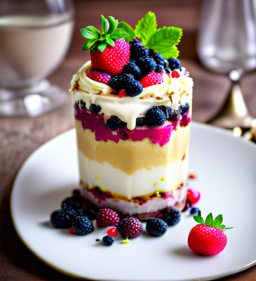

In [42]:
prompt = 'A decadent parfait with layers of creamy goodness and berries.'

generator = generator=torch.Generator('cuda').manual_seed(12367)

gen_image_16 = pipe(prompt,
             generator=generator,
             height=880, # размер итоговой картинки
             width=800, # размер итоговой картинки
             guidance_scale=9.0, # значимость текстового промпта в диффузии, можно увеличить чтобы было больше похоже на промпт
             num_inference_steps=20, # количество шагов диффузии, чем больше тем лучше, но и дольше; поздние шаги изменяют все меньше и меньше
).images[0]

# seed 12362
to_256(gen_image_16)

## обувь

  0%|          | 0/10 [00:00<?, ?it/s]

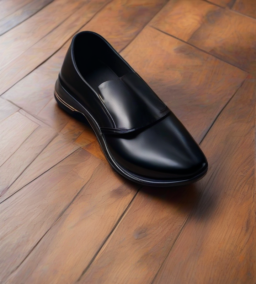

In [44]:
prompt = 'A pair of sleek black leather loafers resting on a polished wooden floor'

generator = generator=torch.Generator('cuda').manual_seed(12344)

gen_image_21 = pipe(prompt,
             generator=generator,
             height=800, # размер итоговой картинки
             width=720, # размер итоговой картинки
             guidance_scale=7.0, # значимость текстового промпта в диффузии, можно увеличить чтобы было больше похоже на промпт
             num_inference_steps=10, # количество шагов диффузии, чем больше тем лучше, но и дольше; поздние шаги изменяют все меньше и меньше
             negative_prompt = 'avoid irrelevant objects'
).images[0]

# seed 12362
to_256(gen_image_21)

  0%|          | 0/15 [00:00<?, ?it/s]

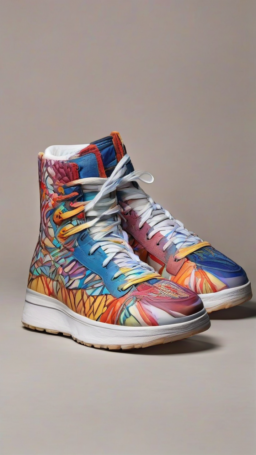

In [45]:
prompt = '"High-top sneakers with colorful patterns and laces undone'

generator = generator=torch.Generator('cuda').manual_seed(12344)

gen_image_22 = pipe(prompt,
             generator=generator,
             height=1280, # размер итоговой картинки
             width=720, # размер итоговой картинки
             guidance_scale=9.0, # значимость текстового промпта в диффузии, можно увеличить чтобы было больше похоже на промпт
             num_inference_steps=15, # количество шагов диффузии, чем больше тем лучше, но и дольше; поздние шаги изменяют все меньше и меньше
             negative_prompt = 'avoid irrelevant objects'
).images[0]

# seed 12362
to_256(gen_image_22)

  0%|          | 0/25 [00:00<?, ?it/s]

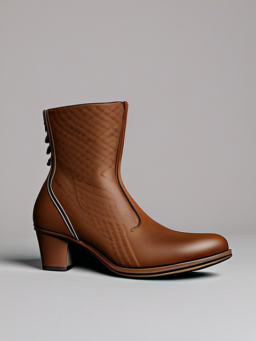

In [46]:
prompt = 'Ankle boots with intricate stitching and a small heel.'

generator = generator=torch.Generator('cuda').manual_seed(12344)

gen_image_23 = pipe(prompt,
             generator=generator,
             height=640, # размер итоговой картинки
             width=480, # размер итоговой картинки
             guidance_scale=7.0, # значимость текстового промпта в диффузии, можно увеличить чтобы было больше похоже на промпт
             num_inference_steps=25, # количество шагов диффузии, чем больше тем лучше, но и дольше; поздние шаги изменяют все меньше и меньше

).images[0]

# seed 12362
to_256(gen_image_23)

  0%|          | 0/24 [00:00<?, ?it/s]

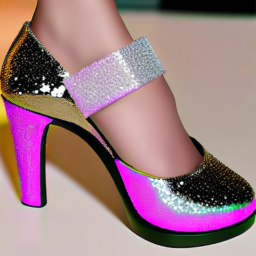

In [49]:
prompt = 'Chunky platform heels adorned with glitter, ready for a night out.'

generator = generator=torch.Generator('cuda').manual_seed(12344)

gen_image_24 = pipe(prompt,
             generator=generator,
             height=480, # размер итоговой картинки
             width=480, # размер итоговой картинки
             guidance_scale=9.0, # значимость текстового промпта в диффузии, можно увеличить чтобы было больше похоже на промпт
             num_inference_steps=24, # количество шагов диффузии, чем больше тем лучше, но и дольше; поздние шаги изменяют все меньше и меньше

).images[0]

# seed 12362
to_256(gen_image_24)

  0%|          | 0/22 [00:00<?, ?it/s]

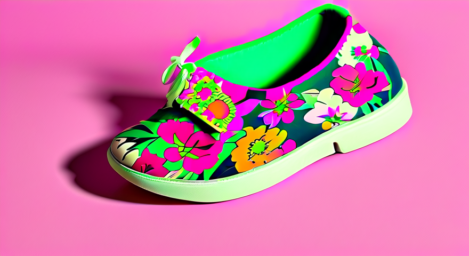

In [53]:
prompt = 'Slip-on flats in a bold floral print, adding a pop of color to any outfit'

generator = generator=torch.Generator('cuda').manual_seed(17844)

gen_image_25 = pipe(prompt,
             generator=generator,
             height=480, # размер итоговой картинки
             width=880, # размер итоговой картинки
             guidance_scale=9.0, # значимость текстового промпта в диффузии, можно увеличить чтобы было больше похоже на промпт
             num_inference_steps=22, # количество шагов диффузии, чем больше тем лучше, но и дольше; поздние шаги изменяют все меньше и меньше


).images[0]

# seed 12362
to_256(gen_image_25)

  0%|          | 0/40 [00:00<?, ?it/s]

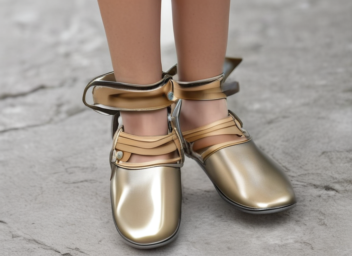

In [56]:
prompt = 'Strappy sandals with metallic buckles, perfect for a summer day.'

generator = generator=torch.Generator('cuda').manual_seed(17247)

gen_image_26 = pipe(prompt,
             generator=generator,
             height=640, # размер итоговой картинки
             width=880, # размер итоговой картинки
             guidance_scale=4.0, # значимость текстового промпта в диффузии, можно увеличить чтобы было больше похоже на промпт
             num_inference_steps=40, # количество шагов диффузии, чем больше тем лучше, но и дольше; поздние шаги изменяют все меньше и меньше

).images[0]

# seed 12362
to_256(gen_image_26)

## дерево

  0%|          | 0/50 [00:00<?, ?it/s]

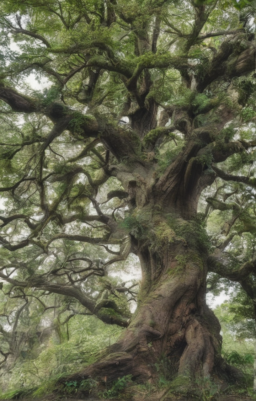

In [73]:
prompt = 'A towering oak with sprawling branches in a lush forest'

generator = generator=torch.Generator('cuda').manual_seed(12344)

gen_image_31 = pipe(prompt,
             generator=generator,
             height=1128, # размер итоговой картинки
             width=720, # размер итоговой картинки
             guidance_scale=2.0, # значимость текстового промпта в диффузии, можно увеличить чтобы было больше похоже на промпт
             num_inference_steps=50, # количество шагов диффузии, чем больше тем лучше, но и дольше; поздние шаги изменяют все меньше и меньше
             negative_prompt = 'do not make it too dramatic'
).images[0]

# seed 12362
to_256(gen_image_31)

  0%|          | 0/20 [00:00<?, ?it/s]

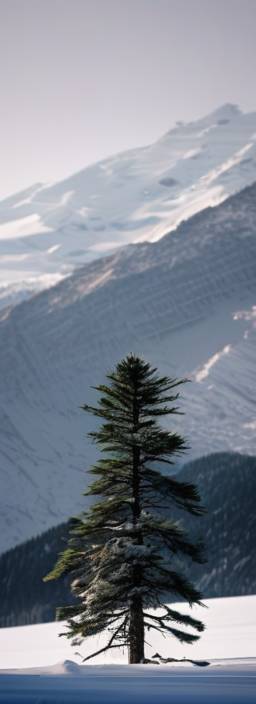

In [74]:
prompt = 'A solitary pine standing tall against a backdrop of snowy mountains.'

generator = generator=torch.Generator('cuda').manual_seed(12344)

gen_image_32 = pipe(prompt,
             generator=generator,
             height=880, # размер итоговой картинки
             width=320, # размер итоговой картинки
             guidance_scale=6.0, # значимость текстового промпта в диффузии, можно увеличить чтобы было больше похоже на промпт
             num_inference_steps=20, # количество шагов диффузии, чем больше тем лучше, но и дольше; поздние шаги изменяют все меньше и меньше
).images[0]

# seed 12362
to_256(gen_image_32)

  0%|          | 0/23 [00:00<?, ?it/s]

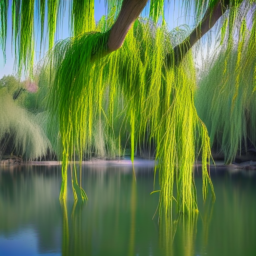

In [75]:
prompt = 'A weeping willow gracefully draping its branches over a serene pond.'

generator = generator=torch.Generator('cuda').manual_seed(12344)

gen_image_33 = pipe(prompt,
             generator=generator,
             height=640, # размер итоговой картинки
             width=640, # размер итоговой картинки
             guidance_scale=9.0, # значимость текстового промпта в диффузии, можно увеличить чтобы было больше похоже на промпт
             num_inference_steps=23, # количество шагов диффузии, чем больше тем лучше, но и дольше; поздние шаги изменяют все меньше и меньше
).images[0]

# seed 12362
to_256(gen_image_33)

  0%|          | 0/30 [00:00<?, ?it/s]

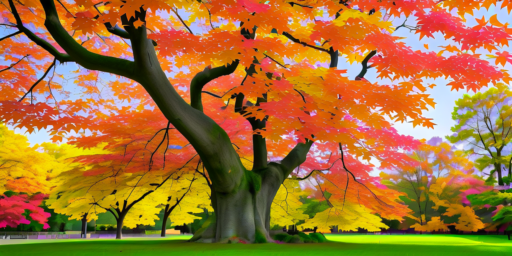

In [76]:
prompt = 'A colorful maple ablaze with autumn foliage in a peaceful park.'

generator = generator=torch.Generator('cuda').manual_seed(12344)

gen_image_34 = pipe(prompt,
             generator=generator,
             height=640, # размер итоговой картинки
             width=1280, # размер итоговой картинки
             guidance_scale=9.9, # значимость текстового промпта в диффузии, можно увеличить чтобы было больше похоже на промпт
             num_inference_steps=30, # количество шагов диффузии, чем больше тем лучше, но и дольше; поздние шаги изменяют все меньше и меньше
).images[0]

# seed 12362
to_256(gen_image_34)

  0%|          | 0/13 [00:00<?, ?it/s]

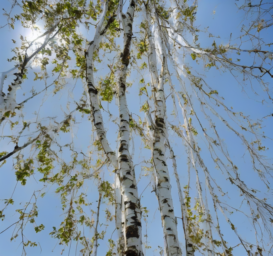

In [77]:
prompt = 'A slender birch with white bark peeling against a clear blue sky.'

generator = generator=torch.Generator('cuda').manual_seed(137945)

gen_image_35 = pipe(prompt,
             generator=generator,
             height=1200, # размер итоговой картинки
             width=1280, # размер итоговой картинки
             guidance_scale=6.0, # значимость текстового промпта в диффузии, можно увеличить чтобы было больше похоже на промпт
             num_inference_steps=13, # количество шагов диффузии, чем больше тем лучше, но и дольше; поздние шаги изменяют все меньше и меньше
).images[0]

# seed 12362
to_256(gen_image_35)

  0%|          | 0/21 [00:00<?, ?it/s]

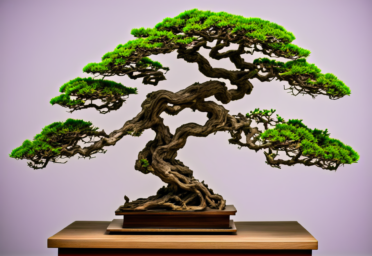

In [78]:
prompt = 'A gnarled bonsai delicately pruned and displayed on a wooden stand.'

generator = generator=torch.Generator('cuda').manual_seed(12344)

gen_image_36 = pipe(prompt,
             generator=generator,
             height=880, # размер итоговой картинки
             width=1280, # размер итоговой картинки
             guidance_scale=9.0, # значимость текстового промпта в диффузии, можно увеличить чтобы было больше похоже на промпт
             num_inference_steps=21, # количество шагов диффузии, чем больше тем лучше, но и дольше; поздние шаги изменяют все меньше и меньше
).images[0]

# seed 12362
to_256(gen_image_36)

## лампа

  0%|          | 0/23 [00:00<?, ?it/s]

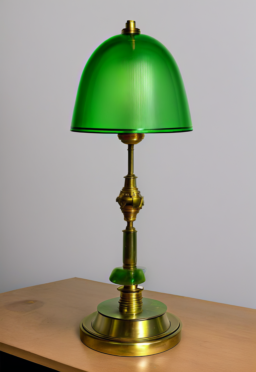

In [79]:
prompt = 'A vintage desk fixture with a brass base and a green glass shade.'

generator = generator=torch.Generator('cuda').manual_seed(12344)

gen_image_41 = pipe(prompt,
             generator=generator,
             height=1280, # размер итоговой картинки
             width=880, # размер итоговой картинки
             guidance_scale=8.0, # значимость текстового промпта в диффузии, можно увеличить чтобы было больше похоже на промпт
             num_inference_steps=23, # количество шагов диффузии, чем больше тем лучше, но и дольше; поздние шаги изменяют все меньше и меньше
).images[0]

# seed 12362
to_256(gen_image_41)

  0%|          | 0/28 [00:00<?, ?it/s]

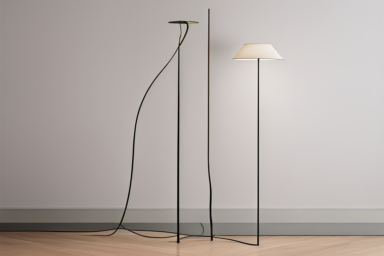

In [85]:
prompt = 'An elegant floor lamp with a curved metal frame.'

generator = generator=torch.Generator('cuda').manual_seed(78453)

gen_image_42 = pipe(prompt,
             generator=generator,
             height=800, # размер итоговой картинки
             width=1200, # размер итоговой картинки
             guidance_scale=7.0, # значимость текстового промпта в диффузии, можно увеличить чтобы было больше похоже на промпт
             num_inference_steps=28, # количество шагов диффузии, чем больше тем лучше, но и дольше; поздние шаги изменяют все меньше и меньше
).images[0]

# seed 12362
to_256(gen_image_42)

  0%|          | 0/13 [00:00<?, ?it/s]

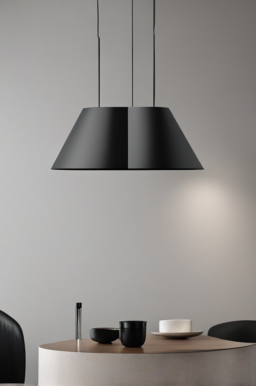

In [86]:
prompt = 'A minimalist pendant fixture with a sleek black finish hanging over a dining table.'

generator = generator=torch.Generator('cuda').manual_seed(12344)

gen_image_43 = pipe(prompt,
             generator=generator,
             height=1208, # размер итоговой картинки
             width=800, # размер итоговой картинки
             guidance_scale=5.0, # значимость текстового промпта в диффузии, можно увеличить чтобы было больше похоже на промпт
             num_inference_steps=13, # количество шагов диффузии, чем больше тем лучше, но и дольше; поздние шаги изменяют все меньше и меньше
).images[0]

# seed 12362
to_256(gen_image_43)

  0%|          | 0/28 [00:00<?, ?it/s]

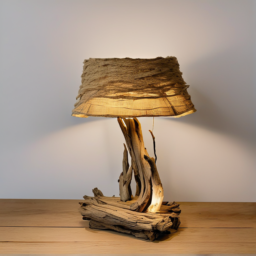

In [87]:
prompt = 'A rustic table light crafted from driftwood with a burlap shade.'

generator = generator=torch.Generator('cuda').manual_seed(12344)

gen_image_44= pipe(prompt,
             generator=generator,
             height=888, # размер итоговой картинки
             width=888, # размер итоговой картинки
             guidance_scale=7.0, # значимость текстового промпта в диффузии, можно увеличить чтобы было больше похоже на промпт
             num_inference_steps=28, # количество шагов диффузии, чем больше тем лучше, но и дольше; поздние шаги изменяют все меньше и меньше
).images[0]

# seed 12362
to_256(gen_image_44)

  0%|          | 0/10 [00:00<?, ?it/s]

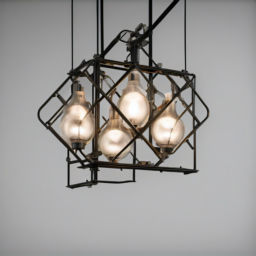

In [88]:
prompt = 'A modern industrial illuminator featuring exposed bulbs and a steel frame.'

generator = generator=torch.Generator('cuda').manual_seed(12344)

gen_image_45 = pipe(prompt,
             generator=generator,
             height=1200, # размер итоговой картинки
             width=1200, # размер итоговой картинки
             guidance_scale=9.4, # значимость текстового промпта в диффузии, можно увеличить чтобы было больше похоже на промпт
             num_inference_steps=10, # количество шагов диффузии, чем больше тем лучше, но и дольше; поздние шаги изменяют все меньше и меньше
).images[0]

# seed 12362
to_256(gen_image_45)

  0%|          | 0/43 [00:00<?, ?it/s]

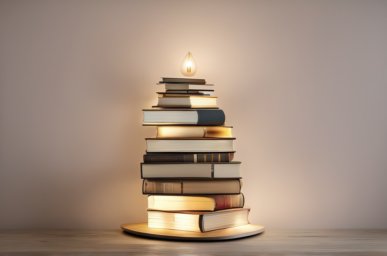

In [89]:
prompt = 'A whimsical bedside lighting shaped like a stack of books with a soft glow'

generator = generator=torch.Generator('cuda').manual_seed(12344)

gen_image_46= pipe(prompt,
             generator=generator,
             height=888, # размер итоговой картинки
             width=1344, # размер итоговой картинки
             guidance_scale=4.0, # значимость текстового промпта в диффузии, можно увеличить чтобы было больше похоже на промпт
             num_inference_steps=43, # количество шагов диффузии, чем больше тем лучше, но и дольше; поздние шаги изменяют все меньше и меньше
).images[0]

# seed 12362
to_256(gen_image_46)

## большие кошки

  0%|          | 0/17 [00:00<?, ?it/s]

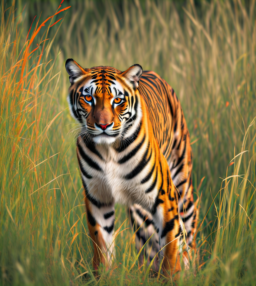

In [90]:
prompt = 'A majestic Bengal predator with vibrant orange stripes prowling through tall grass.'

generator = generator=torch.Generator('cuda').manual_seed(12344)

gen_image_51= pipe(prompt,
             generator=generator,
             height=1344, # размер итоговой картинки
             width=1200, # размер итоговой картинки
             guidance_scale=9.0, # значимость текстового промпта в диффузии, можно увеличить чтобы было больше похоже на промпт
             num_inference_steps=17, # количество шагов диффузии, чем больше тем лучше, но и дольше; поздние шаги изменяют все меньше и меньше
).images[0]

# seed 12362
to_256(gen_image_51)

  0%|          | 0/20 [00:00<?, ?it/s]

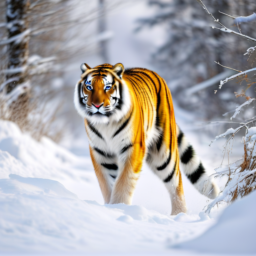

In [93]:
prompt = 'An elusive Siberian tiger blending seamlessly into a snowy landscape'

generator = generator=torch.Generator('cuda').manual_seed(12344)

gen_image_52 = pipe(prompt,
             generator=generator,
             height=800, # размер итоговой картинки
             width=800, # размер итоговой картинки
             guidance_scale=8.0, # значимость текстового промпта в диффузии, можно увеличить чтобы было больше похоже на промпт
             num_inference_steps=20, # количество шагов диффузии, чем больше тем лучше, но и дольше; поздние шаги изменяют все меньше и меньше
).images[0]

# seed 12362
to_256(gen_image_52)

  0%|          | 0/8 [00:00<?, ?it/s]

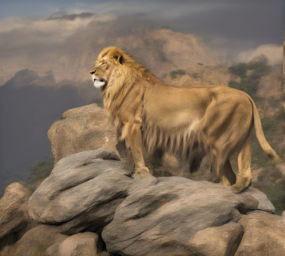

In [98]:
prompt = 'A regal African lion king with a golden mane surveying its pride from atop a rocky outcrop.'

generator = generator=torch.Generator('cuda').manual_seed(12344)

gen_image_53 = pipe(prompt,
             generator=generator,
             height=1200, # размер итоговой картинки
             width=1336, # размер итоговой картинки
             guidance_scale=7.0, # значимость текстового промпта в диффузии, можно увеличить чтобы было больше похоже на промпт
             num_inference_steps=8, # количество шагов диффузии, чем больше тем лучше, но и дольше; поздние шаги изменяют все меньше и меньше
).images[0]

# seed 12362
to_256(gen_image_53)

  0%|          | 0/29 [00:00<?, ?it/s]

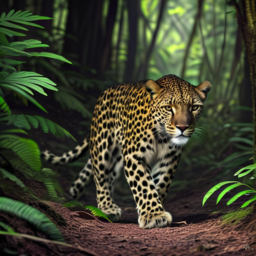

In [99]:
prompt = 'A sleek Javan leopard stalker moving silently through the shadows of the forest floor.'

generator = generator=torch.Generator('cuda').manual_seed(12344)

gen_image_54 = pipe(prompt,
             generator=generator,
             height=720, # размер итоговой картинки
             width=720, # размер итоговой картинки
             guidance_scale=7.0, # значимость текстового промпта в диффузии, можно увеличить чтобы было больше похоже на промпт
             num_inference_steps=29, # количество шагов диффузии, чем больше тем лучше, но и дольше; поздние шаги изменяют все меньше и меньше
).images[0]

# seed 12362
to_256(gen_image_54)

  0%|          | 0/40 [00:00<?, ?it/s]

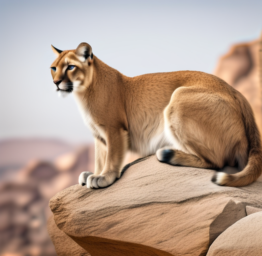

In [101]:
prompt = 'An elegant Arabian cougar resting on a rocky ledge, its golden eyes alert.'

generator = generator=torch.Generator('cuda').manual_seed(12344)

gen_image_55 = pipe(prompt,
             generator=generator,
             height=640, # размер итоговой картинки
             width=656, # размер итоговой картинки
             guidance_scale=9.0, # значимость текстового промпта в диффузии, можно увеличить чтобы было больше похоже на промпт
             num_inference_steps=40, # количество шагов диффузии, чем больше тем лучше, но и дольше; поздние шаги изменяют все меньше и меньше
).images[0]

# seed 12362
to_256(gen_image_55)

  0%|          | 0/18 [00:00<?, ?it/s]

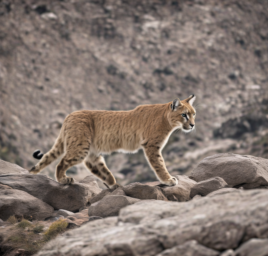

In [104]:
prompt = 'An elusive Andean puma traversing rocky slopes with effortless grace.'

generator = generator=torch.Generator('cuda').manual_seed(46798)

gen_image_56 = pipe(prompt,
             generator=generator,
             height=1280, # размер итоговой картинки
             width=1344, # размер итоговой картинки
             guidance_scale=7.0, # значимость текстового промпта в диффузии, можно увеличить чтобы было больше похоже на промпт
             num_inference_steps=18, # количество шагов диффузии, чем больше тем лучше, но и дольше; поздние шаги изменяют все меньше и меньше
).images[0]

# seed 12362
to_256(gen_image_56)

# кластеризация

In [107]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [109]:
def get_embeddings(images):
    inputs = processor(images=images, return_tensors="pt", padding=True)
    with torch.no_grad():
        embeddings = model.get_image_features(**inputs).numpy()
    return embeddings

In [110]:
images = {
    'icecream': [gen_image_11, gen_image_12, gen_image_13, gen_image_14, gen_image_15, gen_image_16],
    'shoes': [gen_image_21, gen_image_22, gen_image_23, gen_image_24, gen_image_25, gen_image_26],
    'trees': [gen_image_31, gen_image_32, gen_image_33, gen_image_34, gen_image_35, gen_image_36],
    'lamps': [gen_image_41, gen_image_42, gen_image_43, gen_image_44, gen_image_45, gen_image_46],
    'tigers': [gen_image_51, gen_image_52, gen_image_53, gen_image_54, gen_image_55, gen_image_56]
}

In [151]:
all_images = []
labels = []

In [152]:
for idx, (category, image_list) in enumerate(images.items()):
    all_images.extend(image_list)
    labels.extend([idx] * len(image_list))

In [153]:
len(labels)

30

In [154]:
embeddings = get_embeddings(all_images)

In [155]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=0).fit(embeddings)
predicted_labels = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [156]:
import numpy as np

accuracy = np.sum(predicted_labels == labels) / len(labels)
print(f"Clustering accuracy: {accuracy:.2f}")

Clustering accuracy: 0.40


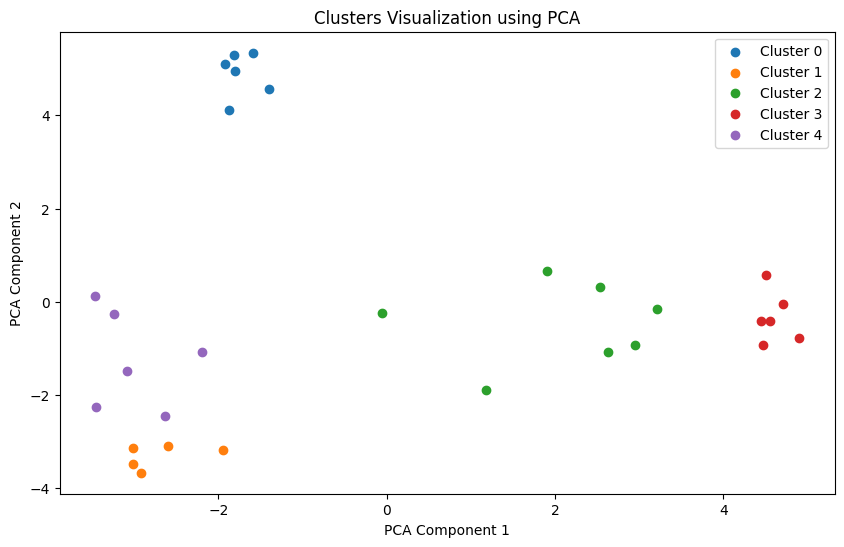

In [157]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

plt.figure(figsize=(10, 6))
for i in range(5):
    plt.scatter(reduced_embeddings[predicted_labels == i, 0], reduced_embeddings[predicted_labels == i, 1], label=f'Cluster {i}')
plt.legend()
plt.title('Clusters Visualization using PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

In [167]:
np.array(labels)

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
       3, 3, 4, 4, 4, 4, 4, 4])

In [133]:
predicted_labels

array([0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1,
       1, 2, 3, 3, 3, 3, 3, 3], dtype=int32)

In [134]:
categories = ['icecream','shoes','trees','lamps','tigers']

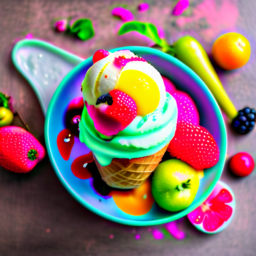


The model assigned this picture (index = 1) to category: icecream


In [162]:
picture_index = 0
display(to_256(all_images[picture_index]))
predicted_label = predicted_labels[picture_index]
category_name = categories[predicted_label]
print(f"\nThe model assigned this picture (index = {picture_index + 1}) to category: {category_name}")


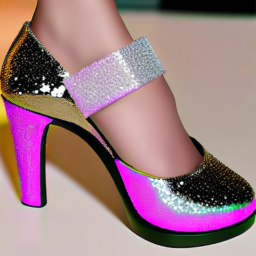


The model assigned this picture (index = 10) to category: tigers


In [161]:
picture_index = 9
display(to_256(all_images[picture_index]))
predicted_label = predicted_labels[picture_index]
category_name = categories[predicted_label]
print(f"\nThe model assigned this picture (index = {picture_index + 1}) to category: {category_name}")

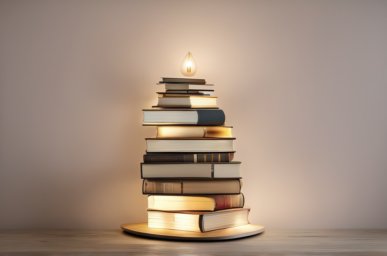


The model assigned this picture (index = 24) to category: trees


In [160]:
picture_index = 23
display(to_256(all_images[picture_index]))
predicted_label = predicted_labels[picture_index]
category_name = categories[predicted_label]
print(f"\nThe model assigned this picture (index = {picture_index + 1}) to category: {category_name}")

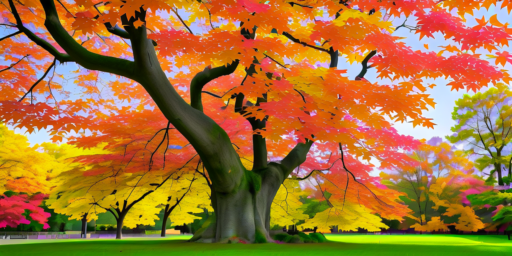


The model assigned this picture (index = 16) to category: trees


In [169]:
picture_index = 15
display(to_256(all_images[picture_index]))
predicted_label = predicted_labels[picture_index]
category_name = categories[predicted_label]
print(f"\nThe model assigned this picture (index = {picture_index + 1}) to category: {category_name}")

In [159]:
from sklearn.metrics import adjusted_rand_score

# Calculate Adjusted Rand Index (ARI)
ari = adjusted_rand_score(labels, predicted_labels)

print(f"Adjusted Rand Index (ARI): {ari}")

Adjusted Rand Index (ARI): 0.9118541033434651


почему то модель поняла только мороженое и деревья